In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
%matplotlib inline

# **1-Reading and exploring the data**

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-12-14 13:35:16--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2024-12-14 13:35:16 (18.1 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
# read it in to inpect it
with open('/content/input.txt',mode ='r',encoding = 'utf-8') as f:
  text = f.read()

In [ ]:
print("length of dataset in characters: ",len(text))

length of dataset in characters:  1115394


In [ ]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [ ]:
# here are all the unique characters that occur in this text

chars = sorted(list(set(text)))
vocab_size = len(chars)
print(' '.join(chars))
print(vocab_size)


   ! $ & ' , - . 3 : ; ? A B C D E F G H I J K L M N O P Q R S T U V W X Y Z a b c d e f g h i j k l m n o p q r s t u v w x y z
65


# **2-Tokenization, train/val split**

In [ ]:
# create a mapping from characters to integers

stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s:[stoi[c] for c in s] # encoder : take a string a list of integers
decode = lambda l: ''.join(itos[i] for i in l) #  decoder : take a list of integers,output a string


print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [ ]:
# let's now encode the entire text dataset and store it into a torch.tensor

data = torch.tensor(encode(text),dtype = torch.long)
print(data.shape, data.dtype)
print(data[:1000])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [ ]:
# let's now split up the data into train and validation sets
n1 = int(0.9*len(data[:]))
train_set = data[:n1] # firts 90% wiil be train, rest val
val_set = data[n1:]
print(f'train_set:{train_set.shape}')
print(f'val_set:{val_set.shape}')

train_set:torch.Size([1003854])
val_set:torch.Size([111540])


#**3-Data loader: batches of chunks of data**

In [ ]:
block_size  = 8
train_set[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [ ]:
print(train_set[:block_size]),print(train_set[1:block_size + 1])

tensor([18, 47, 56, 57, 58,  1, 15, 47])
tensor([47, 56, 57, 58,  1, 15, 47, 58])


(None, None)

In [ ]:
x = train_set[:block_size]
y = train_set[1:block_size+1]

for t in range(block_size):
  context = x[:t+1]
  target  =  y[t]
  print(f"when the input is {context}  - the target: {target}")

when the input is tensor([18])  - the target: 47
when the input is tensor([18, 47])  - the target: 56
when the input is tensor([18, 47, 56])  - the target: 57
when the input is tensor([18, 47, 56, 57])  - the target: 58
when the input is tensor([18, 47, 56, 57, 58])  - the target: 1
when the input is tensor([18, 47, 56, 57, 58,  1])  - the target: 15
when the input is tensor([18, 47, 56, 57, 58,  1, 15])  - the target: 47
when the input is tensor([18, 47, 56, 57, 58,  1, 15, 47])  - the target: 58


In [ ]:
torch.manual_seed(1337)
block_size = 8 # how many  independent sequences will we process in parallel ?
batch_size = 4 # what is the maximun context length for prediction ?

def get_batch(split):
  data = train_set if split == "train" else  val_set
  ix = torch.randint(len(data) - block_size,(batch_size,))
  x = torch.stack([data[i:i+block_size] for  i in ix])
  y = torch.stack([data[i+1:i+block_size+1] for i in ix])
  return x,y

xb, yb  = get_batch("train")
print('inputs')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print(" ================ ")

for b in range(batch_size): # batch dimension
  for t in range(block_size): # time dimension
    context = xb[b,:t+1]
    target  =  yb[b,t]
    print(f"when input is {context.tolist()} the target is {target}")

inputs
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
when input is [24] the target is 43
when input is [24, 43] the target is 58
when input is [24, 43, 58] the target is 5
when input is [24, 43, 58, 5] the target is 57
when input is [24, 43, 58, 5, 57] the target is 1
when input is [24, 43, 58, 5, 57, 1] the target is 46
when input is [24, 43, 58, 5, 57, 1, 46] the target is 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target is 39
when input is [44] the target is 53
when input is [44, 53] the target is 56
when input is [44, 53, 56] the target is 1
when input is [44, 53, 56, 1] the target is 58
when input is [44, 53, 56, 1, 58] the target is 46
w

In [ ]:
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


# **4-Simplest baseline: bigram language model, loss, generation**

In [ ]:
import torch.nn as nn

In [ ]:
torch.manual_seed(1337)
class BigramLanguageModel(nn.Module):
  def __init__(self, vocab_size):
    super().__init__()
    # each token directly reads off the logits for the token  from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size,vocab_size)

  def forward(self, idx, targets = None):
    # idx and targets are both (B,T) tensor of integers
    logits = self.token_embedding_table(idx) #(B,T,C)

    if targets == None:
       loss = None
    else:
      B, T , C  = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits,targets)
    return logits, loss

  def generate(self,idx,max_new_token):
    # idx is (B,T) array of indices  in the current context
    for _ in range(max_new_token):
      # get the predictions
      logits , loss = self(idx)
      # focus on the last time step
      logits = logits[:,-1,:] # becomes (B,C)
      # apply softmax to get probabilities
      probs = F.softmax(logits, dim = -1) # (B,C)
      # sample from the distribuition
      idx_next = torch.multinomial(probs, num_samples = 1) # (B,1)
      # append sampled index to the running sequence
      idx = torch.cat((idx, idx_next),dim = 1) # (B,T+1)

    return idx

m  = BigramLanguageModel(vocab_size)
logits, loss = m(xb,yb)
print(logits.shape)
print(loss)

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)


In [ ]:
print(decode(m.generate(idx = torch.zeros((1,1),dtype = torch.long), max_new_token = 100)[0].tolist()))


Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


# **5- Training  the bigram Model**

In [ ]:
 # create a Pytorch optimizer

optimizer = torch.optim.AdamW(m.parameters(), lr = 1e-3)

In [ ]:
batch_size = 32
for steps in range(10000):
  # sample a batch of data

  # evaluate  the loss
  logits, loss = m(xb,yb)
  optimizer.zero_grad(set_to_none = True)
  loss.backward()
  optimizer.step()
print(loss.item())

0.465354859828949


In [ ]:
print(f'{decode(m.generate(idx=torch.zeros((1,1), dtype=torch.long), max_new_token=400)[0].tolist())}\n')


I t that hat pat t hathethat patxbjPiD&Q!athathat t thathat hat t pathathat hat pat t heat's pathat hat's pat's that's t that t t's thathat that's hathat pat het thathathat that hathet pat theat t t t t that's t t theathat tNw$
I hat thet hathat's t heat hat t t's pat t's pat pat theathethathathat's hethathetheathathat thathathathat's theat's MEO:
I pat that's thathetheat hat hathat's thathathat's



#**6-Building the "self-attention"**

In [ ]:
# consider  the following toy example

torch.manual_seed(1337)
B, T, C = 4, 8, 2 # batch, line, channels
x = torch.randn(B, T, C)

In [ ]:
print(x[0,0].mean(axis=-1))

tensor(0.0554)


In [ ]:
# we want x[b,t] = mean_{i< = t} x[b,i]
xbow = torch.zeros((B, T, C))
for b in range(B):
  for t in range(T):
    xprev = x[b, :t+1]
    xbow[b, t] = torch.mean(xprev, 0)

##**6.1-Version 2: using matrix multiply**

In [ ]:
wei   = torch.tril(torch.ones(T, T))
wei   = wei / wei.sum(1, keepdim = True)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ------> (B, T, C)

## **6.2-Adding softmax**

In [ ]:
# version 3: use Softmax
tril = torch.tril(torch.ones((T,T)))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim = -1)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [ ]:
# version 4: self-attention

torch.manual_seed(1337)
B, T, C  =  4,8,32 # batch , time , channels
x  =  torch.randn(B, T, C)

# let's see a single head perform self-attention

head_size = 16
key   =   nn.Linear(C ,  head_size, bias   = False)
query =   nn.Linear(C ,  head_size, bias   = False)
value =   nn.Linear(C ,  head_size, bias   = False)

k   =  key(x)   #  (B, T, 16)
q   =  query(x) #  (B, T, 16)
v   =  value(x) #  (B ,T, 16)

wei =  q @ k.transpose(-2,-1) # (B, T, 16) @ (B, 16, T) --------> (B,T,T)

tril  =  torch.tril(torch.ones(T, T))
#wei  =  torch.zeros((T, T))
wei   =  wei.masked_fill(tril == 0, float('-inf'))
wei   =  F.softmax(wei, dim = -1)
#out  =  wei @ x
out   =  wei @ v


In [ ]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

#**7- Building the Transformer**

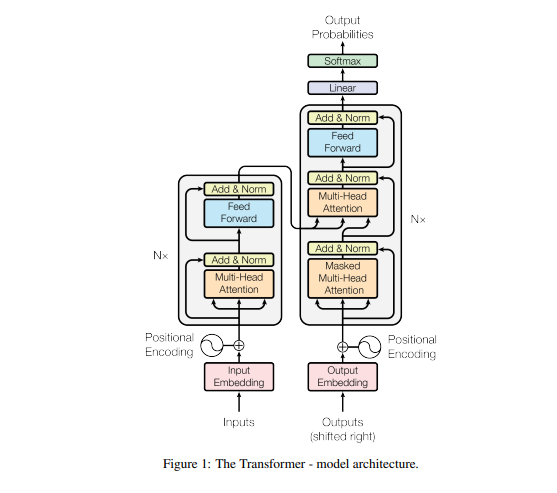

In [ ]:
class BactNorm1d:

  def __init__(self,dim,eps = 1e-5 , momentun = 0.1):
    self.eps = eps
    self.dim = dim
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self,x):
    # calculate the forward pass
    xmean = x.mean(axis   =  1, keepdims = True) # batch mean
    xvar  =  x.var( axis  =  1, keepdims = True,unbiased=False) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    return out

  def parameters(self):
    return [self.gamma, self.beta]

In [ ]:
torch.manual_seed(1337)
module =  BactNorm1d(100)
x = torch.randn(32,100)
x = module(x)
x.shape

torch.Size([4, 8, 16])

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters

batch_size = 64 # how many independent sequences will we process in parallel ?
block_size = 64 # what  is the maximun context length for prediction
max_iters = 5000
eval_interval = 300
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 120
n_head = 8
n_layer = 3
dropout = 0.2

# ----------------------

In [ ]:
class Head(nn.Module):
  """" one head of self attention """

  def __init__(self,head_size):
    super().__init__()
    self.key    = nn.Linear(n_embd, head_size, bias = False)
    self.query  = nn.Linear(n_embd, head_size, bias =  False)
    self.value = nn.Linear(n_embd, head_size, bias = False)
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B, T, C = x.shape
    k = self.key(x)    # [B, T, C]
    q = self.query(x)  # [B, T, C]

    # compute attention scores ("affinites")
    wei = q @ k.transpose(-2,-1)*C**-0.5 # (B, T, C) @ (B, C, T) -----> (B,T,T)
    wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf')) #  (B, T, T)
    wei = F.softmax(wei, dim = -1) # (B, T, T)
    wei = self.dropout(wei)
    # perform the  weigthed aggregation of the  values
    v   = self.value(x)  # (B, T, C)
    out = wei @ v # (B, T, T) @ (B, T, C) ---> (B, T, C)
    return out

class MultiHeadAttention(nn.Module):
  """" multiple heads of self - attention """

  def __init__(self,num_heads,head_size):
    super().__init__()
    self.heads   = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj    = nn.Linear(num_heads * head_size, n_embd)
    self.dropout = nn.Dropout(dropout)

  def forward(self,x):
    out = torch.cat([h(x) for  h in self.heads],dim=-1)
    out = self.dropout(self.proj(out))
    return out

class FeedForward(nn.Module):
  """ a simple linear layer followed by a non - linearity """

  def __init__(self, n_embd):
    super().__init__()
    self.net  = nn.Sequential(
          nn.Linear(n_embd,4 * n_embd),
          nn.ReLU(),
          nn.Linear(4 * n_embd, n_embd),
          nn.Dropout(dropout)
    )

  def forward(self, x):
    return self.net(x)

class Block(nn.Module):
  """" Transformer block: Comunication followeb by computation"""

  def __init__(self, n_embd, n_head):
    # n_embd: embeddings dimension , n_head: the number of heads we'd like
    super().__init__()
    head_size =  n_embd // n_head
    self.sa   = MultiHeadAttention(n_head, head_size)
    self.ffwd = FeedForward(n_embd)
    self.ln1  = nn.LayerNorm(n_embd)
    self.ln2  = nn.LayerNorm(n_embd)

  def forward(self, x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x

class BigramLanguageModel(nn.Module):
  def __init__(self):
    super().__init__()
    # each token directly reads off the logits for the token  from a lookup table
    self.token_embedding_table    = nn.Embedding(vocab_size,n_embd)
    self.position_embbeding_table = nn.Embedding(block_size, n_embd)
    self.blocks    =     nn.Sequential(*[Block(n_embd,n_head = n_head) for _ in range(n_layer)])
    self.ln_f      =     nn.LayerNorm(n_embd)
    self.lm_head   =     nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets = None):

    B, T = idx.shape
    # idx and targets are both (B, T) tensor of integers
    tok_emb =  self.token_embedding_table(idx) # (B,T,C)
    pos_emb =  self.position_embbeding_table(torch.arange(T, device = device))
    x = tok_emb + pos_emb # (B, T, C)
    x = self.blocks(x)    # (B,T,C)
    x = self.ln_f(x)
    logits = self.lm_head(x) # (B, T, vocab_size)

    if targets == None:
       loss = None
    else:
      B, T , C  = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits,targets)
    return logits, loss

  def generate(self,idx,max_new_token):
      # idx is (B,T) array of indices  in the current context
    for _ in range(max_new_token):
      # get the predictions
      idx_cond = idx[:, -block_size:]
      logits , loss = self(idx_cond)
      # focus on the last time step
      logits = logits[:,-1,:] # becomes (B,C)
      # apply softmax to get probabilities
      probs = F.softmax(logits, dim = -1) # (B,C)
      # sample from the distribuition
      idx_next = torch.multinomial(probs, num_samples = 1) # (B,1)
      # append sampled index to the running sequence
      idx = torch.cat((idx, idx_next),dim = 1) # (B,T+1)

    return idx

model  = BigramLanguageModel()
m = model.to(device)

In [ ]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ["train", "eval"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
           X, Y = get_batch(split)
           logits, loss = model(X,Y)
           losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
lossi = []

In [ ]:
 # create a Pytorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), learning_rate)

for iter in range(max_iters):
  # sample a batch of data
    if iter %  eval_interval == 0:
      losses = estimate_loss()
      print(f"steps {iter}: train loss {losses['train']:.4f}, val loss {losses['eval']:.4f}")
     # sample a batch of data
    xb, yb = get_batch("train")
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none = True)
    loss.backward()
    optimizer.step()

In [ ]:
# generate from the model
context = torch.zeros((1,1),dtype = torch.long, device = device)
print(decode(m.generate(context, max_new_token = 10000)[0].tolist()))

In [ ]:
with open('text_genereted.txt', mode = 'w',encoding = 'utf-8') as f:
  f.write(f'{decode(m.generate(context, max_new_token = 10000)[0].tolist())}')

In [ ]:
lossi = estimate_loss()